In [1]:
# import modules
import pandas as pd
import re
import string
import nltk
import numpy as np
from nltk.corpus import stopwords

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.stem.snowball import SnowballStemmer
from dateutil import parser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier

In [2]:
# read data
trn = pd.read_csv("train.csv")

In [3]:
def removeURL(text):
    """
    
    """
    if 'https' in text:
        ret = re.sub(r'https\S+', '', text)
        return ret, 1
    else:
        return text, 0

def removeAt(text):
    if '@' in text:
        ret = re.sub(r'@\S+', '', text)
        return ret, 1
    else:
        return text, 0

def removeHashtag(text):
    if '#' in text:
        ret = re.sub(r'#\S+', '', text)
        return ret, 1
    else:
        return text, 0

In [24]:
vectorizer = TfidfVectorizer(stop_words='english',max_features =10)
def sentence_word_length(text):
 
    sentence_lengths = []
    word_lengths = []
    
    text=re.sub(r"[\?\!]",r" .",text)
    sentences = [s.strip() for s in re.split('[\.]', text) if s]
    
    sentences=list(filter(None,sentences))
    if(sentences == []):
        return (1,1)
    for sentence in sentences:
        words = sentence.split()
        word_lengths = word_lengths + [len(word) for word in words]
        sentence_length = len(words)
        sentence_lengths.append(sentence_length)
    #print(sentence_lengths)
    return (sum(sentence_lengths) / float(len(sentence_lengths)),
            sum(word_lengths) / float(len(word_lengths)))

def process(data,mode='train'):
    
    nRows = len(data.text)
    analyser = SIA()
   
    urls = np.zeros((nRows, 1), dtype=float)
    ats = np.zeros((nRows, 1), dtype=float)
    hashtags = np.zeros((nRows, 1), dtype=float)
    tweetlength=np.zeros((nRows, 1), dtype=float)
    quoted=np.zeros((nRows,1),dtype=float)
    allcap=np.zeros((nRows,1),dtype=float)
    sentiment=np.zeros((nRows,4),dtype=float)
    tokenArr = []
    sent_word_length=np.zeros((nRows,2),dtype=float)
    hours=np.zeros((nRows,1),dtype=float)
    
    
    removewords = stopwords.words("english") + ["via"] + list(string.punctuation)
    
    punctuation_dict = {'commas': ',', 'semicolons': ';', 'exclamations': '!',
                        'periods': '.', 'questions': '?', 'quotes': '"',
                        'ellipses': '...'}
    puncutation_count=np.zeros((nRows,len(punctuation_dict.keys())))
   # df = punctuation_columns(df, 'text', punctuation_dict)
    
    
    filtered_text=[]
    
    text=data.text.tolist()
    for idx in range(len(text)):
        # remove special characters
        
        quoted[idx]=(0 if re.match('^"@', text[idx]) is None else 1)
        for i,p in enumerate(list(punctuation_dict.values())):
            puncutation_count[idx][i]=text[idx].count(p)
        allcap[idx]=len(re.findall('\s([A-Z][A-Z]+)',text[idx]))
        row = text[idx].lower()
        row, urls[idx] = removeURL(row)
        row, ats[idx] = removeAt(row)
        row, hashtags[idx] = removeHashtag(row)
        # remove punctuations
        tweetlength[idx]=len(row)
        sent_word_length[idx]=list(sentence_word_length(re.sub(r"([\.\!\?])",r" \1",row)))
        filtered_text.append(row)
        sentiment_sore=analyser.polarity_scores(row)
        sentiment[idx]=[sentiment_sore['neg'],sentiment_sore['neu'],sentiment_sore['pos'],sentiment_sore['compound']]
        tokens = nltk.word_tokenize(row)
        
        tokens = [token for token in tokens if token not in removewords]
        # hash count
        txtFeature = np.zeros(15)
        for token in tokens:
            txtFeature[hash(token) % 15] += 1
        txtFeature += 1
        tokenArr.append(txtFeature)
        
    tokenArr = np.array(tokenArr, dtype=float)
    
    #tf-idf
    
    if(mode=='train'):  
         vectorizer.fit_transform(filtered_text) 
    freq_term_matrix = vectorizer.transform(filtered_text)

    tf_idf=freq_term_matrix.todense()
    #print(tf_idf.shape)
    # add in timestamp
    tsArr = []
    date=data.created.tolist()
    days=np.zeros((nRows,1),dtype=float)
    times=np.zeros((nRows,1),dtype=float)
    weekend=np.zeros((nRows,1),dtype=float)
    
    for idx in range(len(date)):
        ts = parser.parse(date[idx]).timestamp()
        h=parser.parse(date[idx]).hour
        times[idx]=h
        
        days[idx]=parser.parse(date[idx]).weekday()
        if parser.parse(date[idx]).weekday()==5 or parser.parse(date[idx]).weekday()==6:
            weekend[idx]=1
        else:
            weekend[idx]=0
#         print(ts)
        tsArr.append(ts)
        hours[idx]=h
    tsArr = np.array(tsArr, dtype=float)    
    
    res = np.array(data[['favoriteCount', 'retweetCount']])
    res = np.column_stack((res, urls, ats, hashtags,tweetlength,puncutation_count,allcap,quoted,sent_word_length,days,weekend))
    return res

In [25]:
lbl=trn.label
xTrn, xTst, yTrn, yTst = train_test_split(trn, lbl, test_size=0.2, random_state=42)
xTrn=process(xTrn)
xTst=process(xTst,'test')
from sklearn.preprocessing import normalize, scale

def preprocess(data):
  #  data = scale(data, axis=0)
    return normalize(data, axis=0)

xTrnNorm = preprocess(xTrn)
xTstNorm = preprocess(xTst)


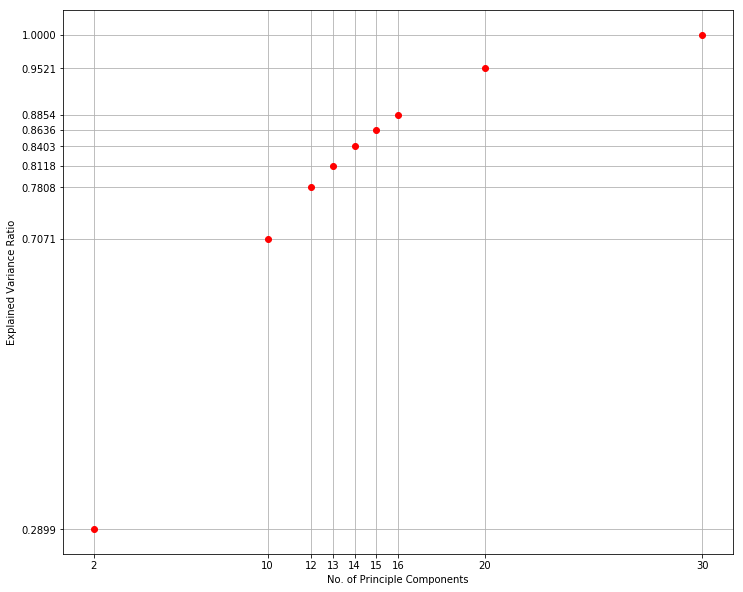

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA()
pca.fit(xTrnNorm)
explained_variance = pca.explained_variance_ratio_
n_components=[2,10,12,13,14,15,16,20,30]
cumulative_var =[np.sum(explained_variance[:i+1]) for i in n_components]
fig2 = plt.figure(figsize = (12,10))
plt.plot(n_components, cumulative_var, 'ro')
plt.grid(True, which = 'both')
plt.yticks(cumulative_var)
plt.xticks(n_components)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("No. of Principle Components")
plt.show()
plt.show()

In [15]:
#different models

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=2000, max_depth=5, random_state=2)
clf.fit(xTrnNorm, yTrn)

# validation
pred = clf.predict(xTstNorm)
isAcc = pred == yTst
acc = np.count_nonzero(isAcc) / len(isAcc)
print(acc)

from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators =5,learning_rate =0.4)
clf.fit(xTrnNorm, yTrn)
pred = clf.predict(xTstNorm)
isAcc = pred == yTst
acc = np.count_nonzero(isAcc) / len(isAcc)
print(acc)

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators =100,learning_rate =0.1,max_depth=1)
clf.fit(xTrnNorm, yTrn)
pred = clf.predict(xTstNorm)
isAcc = pred == yTst
acc = np.count_nonzero(isAcc) / len(isAcc)
print(acc)

from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(xTrnNorm, yTrn)
pred = clf.predict(xTstNorm)
isAcc = pred == yTst
acc = np.count_nonzero(isAcc) / len(isAcc)
print(acc)

clf = GaussianNB()
clf.fit(xTrnNorm, yTrn)
pred = clf.predict(xTstNorm)
isAcc = pred == yTst
acc = np.count_nonzero(isAcc) / len(isAcc)
print(acc)

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(xTrnNorm, yTrn)
pred = clf.predict(xTstNorm)
isAcc = pred == yTst
acc = np.count_nonzero(isAcc) / len(isAcc)
print(acc)


0.8669724770642202
0.8669724770642202
0.8623853211009175
0.5871559633027523
0.8394495412844036
0.8669724770642202


In [16]:
pca = PCA(n_components=2)
pca.fit(xTrnNorm)
xTrnNorm1 = pca.transform(xTrnNorm)
xTstNorm1 = pca.transform(xTstNorm)


from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(xTrnNorm1, yTrn)
pred = clf.predict(xTstNorm1)
isAcc = pred == yTst
acc = np.count_nonzero(isAcc) / len(isAcc)
print(acc)

clf = GaussianNB()
clf.fit(xTrnNorm1, yTrn)
pred = clf.predict(xTstNorm1)
isAcc = pred == yTst
acc = np.count_nonzero(isAcc) / len(isAcc)
print(acc)



0.8073394495412844
0.8027522935779816


In [26]:

from sklearn.ensemble import RandomForestClassifier
x=[1,2,3,4,5,6,7,8,9]
acc_total=np.zeros(len(x))
for i,depth in enumerate(x):
    clf = RandomForestClassifier(n_estimators=2000, max_depth=depth, random_state=2)
    clf.fit(xTrnNorm, yTrn)

    # validation
    pred = clf.predict(xTstNorm)
    isAcc = pred == yTst
    acc = np.count_nonzero(isAcc) / len(isAcc)
    acc_total[i]=acc


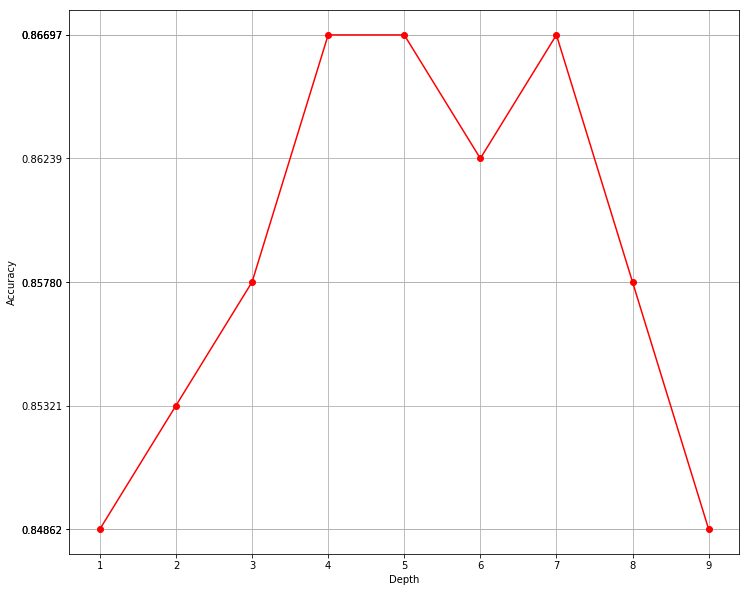

In [27]:
fig3 = plt.figure(figsize = (12,10))
plt.plot(x, acc_total, 'ro-')
plt.grid(True, which = 'both')
plt.yticks(acc_total)
plt.xticks(x)
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.show()

In [20]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators =5,learning_rate =0.4)
clf.fit(xTrnNorm, yTrn)
pred = clf.predict(xTstNorm)
isAcc = pred == yTst
acc = np.count_nonzero(isAcc) / len(isAcc)
print(acc)


0.8669724770642202


In [689]:

clf = GradientBoostingClassifier(n_estimators =75,learning_rate =0.1,max_depth=1)
clf.fit(xTrnNorm, yTrn)
pred = clf.predict(xTstNorm)
isAcc = pred == yTst
acc = np.count_nonzero(isAcc) / len(isAcc)
print(acc)

0.8577981651376146


In [32]:
trnNorm.shape

(1089, 19)

In [40]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,UpSampling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau


processedTrn=process(trn)
trnNorm = preprocess(processedTrn)
# do test


tst = pd.read_csv('test.csv')

processedTst = process(tst,'test')

tstNorm = preprocess(processedTst)

pca = PCA(n_components=3)
pca.fit(trnNorm)
xTrnNorm1 = pca.transform(trnNorm)
xTstNorm1 = pca.transform(tstNorm)

lbl[lbl==-1]=0
lbl
trn1=trnNorm.reshape((-1,trnNorm.shape[1]))
tst1=tstNorm.reshape((-1,trnNorm.shape[1]))
train_l = to_categorical(lbl , num_classes = 2)
x_trn, x_tst, y_trn,y_tst = train_test_split(trn1, train_l, test_size = 0, random_state=0)

model = Sequential()
model.add(Dense(256, input_dim=trnNorm.shape[1],kernel_initializer='normal',activation ='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation = "softmax"))
# Define the optimizer
optimizer = Adam(lr=0.005)

epochs = 3 # Turn epochs to 30 to get 0.9967 accuracy
size = 1
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.75, 
                                            min_lr=0.00001)
model.summary()          
model.fit(x_trn,y_trn, batch_size=size, epochs = epochs,verbose = 1, callbacks=[learning_rate_reduction])


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               5120      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 514       
Total params: 5,634
Trainable params: 5,634
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1089/1089 [==============================] - 1s 1ms/step - loss: 0.4028 - acc: 0.8292
Epoch 2/3
1089/1089 [==============================] - 1s 1ms/step - loss: 0.3088 - acc: 0.8669
Epoch 3/3
1089/1089 [==============================] - 1s 964us/step - loss: 0.3153 - acc: 0.8696


In [41]:
y_pred=model.predict(tstNorm)
y_pred_classes  = np.argmax(y_pred,axis = 1)
y_pred_classes[y_pred_classes==0]=-1
y_pred_classes

array([ 1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,
        1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1,  1,  1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1,  1,  1, -1,
        1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,
        1,  1, -1,  1,  1

In [42]:


prediction = []
for i,d in enumerate(y_pred_classes):
    prediction.append((i,d))

labels = ['ID','Label']
df = pd.DataFrame.from_records(prediction, columns=labels)
df.to_csv("nn9.csv",index=False,header=True,sep=",")
print('done')
    


done
